Using the other object as test set 🤪

In [1]:
# # Bonus cell for using the different test set

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import pathlib
# from copy import copy
# from matplotlib import cm, colors
# import cv2

# objectwidth = 100
# objectheight = 100
# xspacing = 116
# yspacing = 300
# xstart = 293
# ystart = 445
# xend = 1730
# yend = 1770
# powderthickness = 80
# endlayer = 225

# paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
# paths_sorted = [x for x in paths]
# paths_sorted.sort()
# integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])

# objectinfo = pd.read_csv('Parameters2.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
# objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
# objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
#     ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
# coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
# objectinfo = coorddf.join(objectinfo)

# del coorddf
# del objectCoordinates
# del paths_sorted

# objectinfo.drop(objectinfo[objectinfo.Label == 'KH'].index, inplace=True)
# objectinfo.replace('GOOD', 0, inplace=True)
# objectinfo.replace('LOF', 1, inplace=True)
# objectinfo.reset_index(drop=True, inplace=True)

# objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

# for index, object in objectinfo.iterrows():
#     objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
# del integrals

# aggregate = np.sum(objects, axis=(0))

# emptyRatio = 30
# limit = np.percentile(aggregate, emptyRatio)
# testmask = aggregate >= limit

# testobjects = objects
# testobjectinfo = objectinfo
# del objects
# del objectinfo

In [15]:
# Read train data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

emptyRatio = 47
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 187
objectsplit = 3
upsamplingratio = 4
positive_multiplier = 2

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
integrals = block[0:endlayer]

del paths_sorted
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])

layersPerObject = endlayer // objectsplit
testEnd = endlayer - layersPerObject * (objectsplit // 3)
# testEnd = endlayer

objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)
objectinfo.drop(objectinfo[objectinfo.Label == 'KH'].index, inplace=True)
objectinfo.replace('GOOD', 0, inplace=True)
objectinfo.replace('LOF', 1, inplace=True)

zs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject, layersPerObject//(upsamplingratio * positive_multiplier))]
testzs = [objectinfo.copy().assign(zstart=testEnd, zend=endlayer)]
trainobjectinfo = pd.concat(zs, ignore_index=True)
# This line removes all the lines from the dataframe that aren't created because of the positive_multiplier
trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]
testobjectinfo = pd.concat(testzs, ignore_index=True)

trainobjectinfo.reset_index(drop=True, inplace=True)
testobjectinfo.reset_index(drop=True, inplace=True)

del zs
del coorddf
del objectCoordinates
del objectinfo

trainobjects = np.full((len(trainobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)
testobjects = np.full((len(testobjectinfo), endlayer-testEnd, objectheight, objectwidth), np.nan)

for index, object in trainobjectinfo.iterrows():
    trainobjects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]

for index, object in testobjectinfo.iterrows():
    testobjects[index-1] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]

aggregate = np.sum(trainobjects, axis=(0,1))

emptyRatio = 47
limit = np.percentile(aggregate, emptyRatio)
trainmask = aggregate >= limit
trainmask = np.repeat([trainmask], layersPerObject, 0)

testmask = trainmask

del aggregate
del limit
del integrals
del block
del paths
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [3]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import preprocessing
from datetime import datetime

def preprocess(objects, type, sharpening, backgroundmask):
    rtn = np.full(objects.shape, np.nan)
    # print(rtn.shape)
    for index, object in enumerate(objects):
        sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
        sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
        # if(sharpening == 'none'):
        #     sharpened = object
    # Sharpening is done
        if type == 'scatter' or type == 'spatstat':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            (endLayer, _, _) = xs.shape
            xs[~backgroundmask] = np.nan
            rtn[index] = xs
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            (endLayer, _, _) = xs.shape
            avg = np.mean(xs, where=backgroundmask)
            stddev = np.std(xs, where=backgroundmask)
            xs = (xs - avg) / avg
            xs[~backgroundmask] = np.nan
            rtn[index] = xs
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    c, z, y, x = objects.shape

    outlierValues = np.full((c, z + 1 - windowSize, y, x), np.nan)
    for index in range(0, c):
        object = objects[index]
        # Step 1: calculate neighbourhood
        neighbourkernel = np.array(
            [[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]
        )/9 if neighbourhoodSetting == 'grid' else np.array(
            [[1, 2,  1],
            [2, 4, 2],
            [1, 2,  1]])/16
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1

        xs = object[offset:z-endoffset]
        ys = neighbourhoodValues[0:z-windowSize+1]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

        # plt.imshow(xs[0])
        # plt.figure()
        # plt.imshow(xs[0])
        # plt.figure()
        # if(index == 58):
        #     plt.imshow(xs[0])
        #     plt.figure()
        #     plt.imshow(ys[0])
        #     plt.figure()
        #     plt.imshow(filter[0])
        #     plt.figure()
        #     print(len(np.unique(filter)))
        numberOfFilterValues = len(np.unique(filter))
        # print("filterlength is: ", numberOfFilterValues)
        # print("index is:", index)
        assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
        if type == 'spatstat':
            outliers = xs - ys
            avg = np.mean(outliers[filter])
            std = np.std(outliers[filter])
            outliers = (outliers - avg) / std
            outlierValues[index] = outliers
        else:
            # Is the axis right for moran/scatter?
            # print(offset, endoffset, object.shape)
            line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
            p = np.poly1d(line)
            outlierValues[index] = xs - p(ys)
            assert(outlierValues[index].shape == xs.shape == p(ys).shape)
        assert(len(np.unique(outlierValues[index])) > 1)
        assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
    assert(np.average(np.isfinite(outlierValues)) > 0.4)
    return outlierValues

def encode(outlierobjects, type, buckets, histnormalise, minval=0, maxval=0):
    numberOfObjects, _, _, _ = outlierobjects.shape
    X = np.full((numberOfObjects, buckets), np.nan)
    filter = np.isfinite(outlierobjects)
    minval = np.min(outlierobjects[filter]) if minval == 0 else minval
    maxval = np.max(outlierobjects[filter]) if maxval == 0 else maxval
    for index in range(0, numberOfObjects):
        xs = outlierobjects[index]
        filter = np.isfinite(xs)
        hist, edges = np.histogram(xs[filter], bins=buckets, range=(minval, maxval), density=True)
        X[index] = np.array(hist)
    
    if (histnormalise == 'column'):
        X = preprocessing.normalize(X, axis=0)
    elif (histnormalise == 'row'):
        X = preprocessing.normalize(X, axis=1)
    return X, minval, maxval, edges

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
    cvs = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict(Xtest)
    return cvs.mean() - cvs.std(), metrics.roc_auc_score(Ytest, yfit), metrics.precision_score(Ytest, yfit, zero_division=0), metrics.recall_score(Ytest, yfit, zero_division=0)

In [13]:
# parameter settings
types = ['scatter', 'spatstat', 'moran', ]
sharpening = ['none', 'direct', 'diagonal']
windowsizes = [1, 3, 5, 7]
neighbourhoodSetting = ['grid', 'euclidean']
bins = [30, 60, 90, 120, 150]
histnormalise = ['none', 'row']
k = [2,3,4,5,10,15,20]

16:37:44 Processing type:  scatter  sharpening:  none
16:37:45 Processing windowSize:  1  neighbourhood:  grid
16:37:56 Processing histnorm:  none  bins:  30


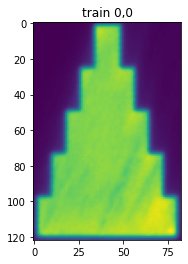

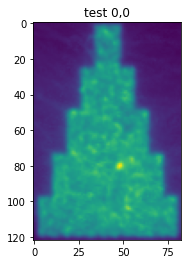

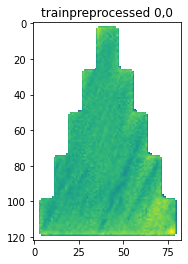

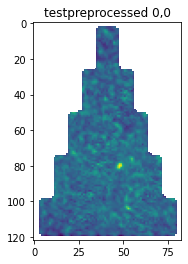

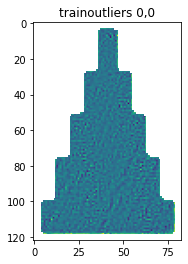

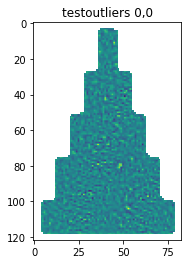

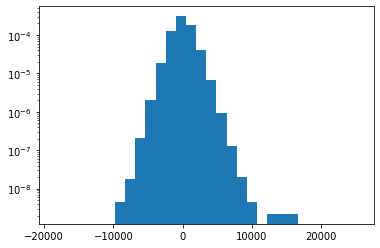

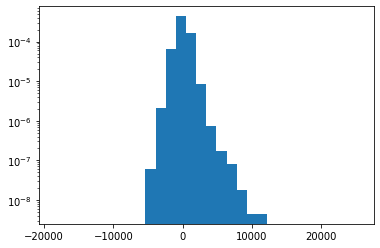

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [16]:
# Now to tie it all together...
def doStuff ():
    columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'cv-auc', 'test-auc', 'test-precision', 'test-recall']
    results = pd.DataFrame(columns=columns)
    Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
    Ytest = np.array(testobjectinfo.loc[:,"Label"])
    for type in types:
        for sharpSetting in sharpening:
            print(datetime.now().strftime("%H:%M:%S"), "Processing type: ", type, " sharpening: ", sharpSetting)
            # trainpreprocessed = np.apply_along_axis(preprocess, 1, trainobjects, type, sharpSetting)
            trainpreprocessed =preprocess(trainobjects, type, sharpSetting, trainmask)
            testpreprocessed =preprocess(testobjects, type, sharpSetting, testmask)
            plt.imshow(trainobjects[0][0])
            plt.title("train 0,0")
            plt.figure()
            plt.imshow(testobjects[0][0])
            plt.title("test 0,0")
            plt.figure()
            plt.imshow(trainpreprocessed[0][0])
            plt.title("trainpreprocessed 0,0")
            plt.figure()
            plt.imshow(testpreprocessed[0][0])
            plt.title("testpreprocessed 0,0")
            plt.figure()
            for windowsize in windowsizes:
                for nSetting in neighbourhoodSetting:
                    print(datetime.now().strftime("%H:%M:%S"), "Processing windowSize: ", windowsize, " neighbourhood: ", nSetting)
                    # trainoutliers = np.apply_along_axis(calculateoutliers, 1, trainpreprocessed, type, nSetting, windowsize)
                    trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
                    testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)

                    plt.imshow(trainoutliers[0][0])
                    plt.title("trainoutliers 0,0")
                    plt.figure()
                    plt.imshow(testoutliers[0][0])
                    plt.title("testoutliers 0,0")
                    plt.figure()
                    for histnorm in histnormalise:
                        for bincount in bins:
                            print(datetime.now().strftime("%H:%M:%S"), "Processing histnorm: ", histnorm, " bins: ", bincount)
                            Xtrain, minval, maxval, edges = encode(trainoutliers, type, bincount, histnorm)
                            Xtest, _, _, _ = encode(testoutliers, type, bincount, histnorm, minval=minval, maxval=maxval)
                            plt.hist(edges[0:-1], weights=Xtrain[0], bins=edges)
                            plt.yscale('log')
                            plt.figure()
                            plt.hist(edges[0:-1], weights=Xtest[0], bins=edges)
                            plt.yscale('log')
                            plt.figure()
                            # print(edges)
                            # data = [1, 2, 2, 3, 4, 5, 5, 5, 5, 6, 10]
                            # counted_data = {1: 1, 2: 2, 3: 1, 4: 1, 5: 4, 6: 1, 10: 1}
                            # hh = plt.hist(data, bins=len(data), color='red', label="data")
                            # hh1 = plt.hist(counted_data.keys(), weights=counted_data.values(),
                            # bins=range(10), rwidth=.95, label="counted_data")
                            plt.figure()
                            # Add encode for test as well
                            for n_neighbors in k:
                                cvscore, score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors)
                                nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bincount, histnorm, n_neighbors, cvscore, score, precision, recall]], columns=columns)
                                results = pd.concat([results, nextRow])
                            results.to_csv('out14.csv', index=False, header=True)
                            return
doStuff()

In [21]:
print("trainobjects (numpy): " + str(hash(np.array2string(trainobjects))))
print("traininfo: " + str(hash(trainobjectinfo.to_string())))
print("testobjects (numpy): " + str(hash(np.array2string(testobjects))))
print("testinfo: " + str(hash(testobjectinfo.to_string())))

trainobjects (numpy): -2166023118416099643
traininfo: 412508232648793926
testobjects (numpy): 4546364536014759216
testinfo: -8326825392638724975


In [22]:
trainobjectinfo.to_csv("v3train.csv", index=False, header=True)